In [1]:
from datetime import date
from qutip import *
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
def plot_wigner(rho, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax=plt.subplots(1,1,figsize=(8,8))
    if isket(rho):
        rho=ket2dm(rho)
    xvec=linspace(-7.5, 7.5, 200)
    W=wigner(rho,xvec,xvec)
    wlim=abs(W).max()
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'x1', fontsize=16)
    ax.set_ylabel(r'x2', fontsize=16)
    return fig, ax

In [3]:
class system:
    def __init__(self, chi, tau_speed, ramp, catsize, start, stop, num):
        self.purechi=chi
        self.chi=chi*(2)*pi
        self.ramp=ramp
        self.catsize=catsize
        self.tau_speed=tau_speed
        self.tau=self.tau_speed/self.chi #puri=5, frattini=2.14
        self.start=start
        self.stop=stop
        self.num=num
        self.tlist=linspace(self.start, self.stop, self.num)
        self.N=15
        self.x_chi=[]
        self.y_v=[]
        self.fidelity=[]
        self.a=destroy(self.N)
        self.ad=self.a.dag()
        self.H0=self.ad*self.ad*self.a*self.a
        self.Hdet=self.ad*self.a
        self.Hx=self.ad*self.ad+self.a*self.a
        self.Hy=self.ad*self.ad-self.a*self.a
        self.zero=basis(self.N, 0)
        self.one=basis(self.N, 1)
        self.N_plus=(1/(sqrt(2*(1+(exp((-2)*self.catsize))))))
        self.zero=coherent(self.N, 0)
        self.P0=self.catsize*self.chi
        self.expectedcat=self.N_plus*(coherent(self.N, sqrt(self.catsize))+coherent(self.N, -sqrt(self.catsize)))
    def Epx(self, t, args):
        if self.ramp == 'exp':
            return self.P0 *(1-exp((-(t)**4)/(self.tau**4)))
        elif self.ramp == 'tanh':
            return self.P0*tanh(4*(t/self.tau))
        elif self.ramp == 'lin':
            if t<self.tau:
                return self.P0*(t/self.tau) 
            if t>=self.tau :
                return self.P0
        elif self.ramp =='inst':
            return self.P0   
    def det(self, t, args):
        return (-1.7)*(self.chi)*(1-(t/self.tau))     
    def Epy(self, t,args):
        Ep= self.P0*self.chi*(1-exp((-(t)**4)/(self.tau**4)))
        alpha_0=sqrt(Ep/self.chi)
        alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/(self.tau**4)))))*((-1)*self.catsize*exp((-(t)**4)/(self.tau**4)))*((-4)*(t**3)/(self.tau**4)))
        N_m=1/(sqrt(2*(1-exp((-2)*(self.catsize)))))
        return (1j*alpha_prime)/((1+2*alpha_0)*(N_m))
    def init_fidelity(self, spec, type, kstart, kstop, knum, vstart, vstop, vnum): 
        kerr=linspace(kstart, kstop, knum)
        tau_speed=linspace(vstart,vstop, vnum) # adiabatic cond tau>>1/(Delta_gap=4Kn) =>min v=0.1!(JW setting)
        x=[]
        y=[]
        fid=[]
        for chi in kerr:
            for v in tau_speed:
                if type=='ref':
                    def Epx_k_v(t, args):
                        return (2*pi)*chi*self.catsize*(1-exp((-(t)**4)/((v/(2*pi)*chi)**4)))
                    result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_v]],self.zero, self.tlist, [], [])
                elif type=='det':
                    def detuning(t, args):
                        return (-1.7)*(2*pi*chi)*(1-(t/(v/(2*pi*chi))))
                    def Epx_k_v(t, args):
                        if t<(v/(2*pi*chi)):
                            return self.catsize*2*pi*chi*(t/(v/(2*pi*chi))) 
                        if t>=(v/(2*pi*chi)) :
                            return self.catsize*2*pi*chi
                    result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_v],[self.Hdet, detuning]],self.zero, self.tlist, [], [])
                
                f=[]
                t=[]
                for i in range(len(self.tlist)):
                    f.append(fidelity(self.expectedcat, result.states[i]))
                maxfid=max(f)
                maxfid_idx=f.index(maxfid)
                f.clear()
                self.x_chi.append(chi)
                self.y_v.append(v)
                self.fidelity.append(round(maxfid*100,2))
                if maxfid<0.9:
                    pass
                if maxfid>=0.9:
                    x.append(chi)
                    y.append(v)
                    fid.append(round(maxfid*100,2))
                    time_taken=((self.stop-self.start)/self.num)*(maxfid_idx+1)
        print(fid)
        plt.scatter(x,y,c=fid, s=20, cmap=plt.cm.viridis, alpha=1,vmin=90, vmax=100)
        #plt.scatter(self.x_chi,self.y_v,c=self.fidelity, s=20, cmap=plt.cm.viridis, alpha=1)
        plt.xlabel('kerr(MHz)')
        plt.ylabel('ramp speed')
        plt.colorbar(label='fidelity(%)')
        name=f"{spec},n={self.catsize},k=({kstart},{kstop},{knum}),v=({vstart},{vstop},{vnum})"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/data/fidelity/230214/{name}.png"
        plt.savefig(file_name, format='png', dpi=100, bbox_inches='tight')
        plt.show()
        
    def generate(self, H, spec, speed):
        n=len(self.tlist)
        if H=='x':
            H=[(-1)*self.chi*self.H0,[self.Hx, self.Epx]]
        elif H=='x,y':
            H=[(-1)*self.chi*self.H0,[self.Hx, self.Epx],[self.Hy, self.Epy]]
        elif H=='x,det':
            H=[(-1)*self.chi*self.H0,[self.Hx, self.Epx],[self.Hdet, self.det]]
        result=mesolve(H, self.zero, self.tlist, [], [])        
        # fidelity, time
        f=[]
        for i in range(n):
            f.append(fidelity(self.expectedcat, result.states[i]))
        maxfid=max(f)
        maxfid_idx=f.index(maxfid)
        time_taken=((self.stop-self.start)/self.num)*(maxfid_idx+1)
        # animation
        fig, ax= plt.subplots(1,1,figsize=(8,8))
        def update(frame):
            plot_wigner(result.states[frame*speed], fig=fig, ax=ax)
        ani=animation.FuncAnimation(fig, update, frames=int(n/speed))
        FFwriter=animation.FFMpegWriter()
        name=f"n={spec},({self.purechi},{self.tau_speed},{self.catsize}),F,t=({round(maxfid*100,2)},{round(time_taken,2)}us),({self.ramp},{H}),t=({self.start},{self.stop},{self.num}).mp4"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/animation/230214/{name}.mp4"
        ani.save(file_name, writer=FFwriter)
        plt.close()
        return maxfid, time_taken

In [4]:
sys=system(chi=1, tau_speed=1, ramp=None, catsize=2, start=0, stop=2,num=2000)


In [6]:
t=system(chi=0.75, tau_speed=5, ramp='exp', catsize=2, start=0, stop=2,num=500)


In [ ]:
t.generate(H='x',spec='test',speed=20)

[93.17, 96.79, 98.74, 99.52, 99.55, 99.53, 99.81, 99.95, 99.98, 99.97, 99.99, 100.0, 100.0, 99.97, 99.83, 99.58, 99.17, 98.42, 97.26, 95.74, 93.94, 91.88, 91.96, 99.54, 99.97, 100.0, 100.0, 100.0, 100.0, 100.0, 99.89, 99.22, 97.34, 93.96, 99.84, 100.0, 100.0, 100.0, 100.0, 99.83, 98.07, 93.09, 100.0, 100.0, 100.0, 99.99, 98.78, 92.47, 100.0, 100.0, 100.0, 98.6, 95.94, 100.0, 100.0, 99.67, 91.49, 99.46, 100.0, 100.0, 96.99, 99.64, 100.0, 99.96, 90.63, 99.97, 100.0, 99.47, 100.0, 100.0, 97.67, 100.0, 100.0, 94.05, 100.0, 100.0, 100.0, 100.0, 100.0, 99.99, 100.0, 99.95, 100.0, 99.79, 100.0, 99.36, 100.0, 98.52, 100.0, 97.17, 100.0, 95.28, 100.0, 92.93, 100.0, 90.21, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


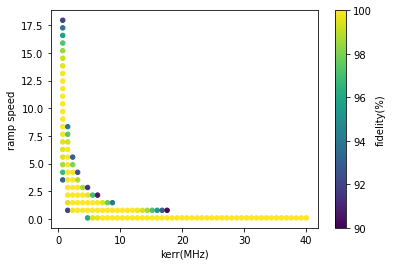

In [42]:
sys.init_fidelity('ref',type='ref',
kstart=0.75, kstop=40, knum=50,
vstart=0.1, vstop=20, vnum=30)

[93.49, 94.74, 96.54, 98.21, 98.92, 99.18, 99.62, 99.72, 99.87, 99.91, 99.97, 99.98, 99.99, 99.98, 99.75, 99.23, 98.57, 96.92, 95.23, 92.64, 94.76, 99.71, 99.99, 100.01, 100.01, 100.01, 100.0, 99.77, 98.12, 93.63, 99.97, 100.01, 100.01, 100.01, 99.8, 96.18, 100.01, 100.01, 100.01, 98.76, 94.62, 100.01, 100.01, 99.37, 98.68, 100.01, 100.01, 92.28, 99.72, 100.01, 99.65, 99.97, 100.01, 96.8, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 99.95, 100.01, 99.58, 100.01, 98.46, 100.01, 96.12, 100.01, 92.41, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01]


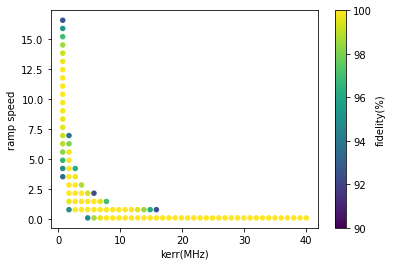

In [40]:
sys.init_fidelity('ref',type='ref',
kstart=0.75, kstop=40, knum=40,
vstart=0.1, vstop=20, vnum=30)

[92.25, 94.77, 97.72, 98.96, 99.52, 99.74, 99.91, 99.97, 99.99, 99.91, 99.42, 98.15, 95.42, 91.27, 98.92, 99.99, 100.01, 100.01, 99.93, 97.68, 100.01, 100.01, 99.99, 95.49, 100.01, 100.01, 93.82, 94.6, 100.01, 99.19, 98.63, 100.01, 91.29, 99.72, 100.01, 99.97, 99.99, 100.01, 99.6, 100.01, 97.61, 100.01, 92.88, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01, 100.01]


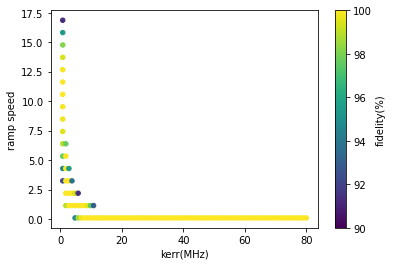

In [39]:
sys.init_fidelity('ref',type='ref',
kstart=0.75, kstop=80, knum=80,
vstart=0.1, vstop=20, vnum=20)